In [1]:
import sys
import pickle
import subprocess
import numpy as np
import networkx as nx
import pygraphviz
from collections import Counter, defaultdict

The next cell loads all the data we want to derive our features from including the original dense embeddings themselves, the fca-derived dag and word frequency information.  
Note that dense embeddings are assumed to be located at `./dense_matrices`.  
The `*.dot` files should be placed at `./dag`.  
It is also important to set the `dataset_dir` at your convenience.

In [2]:
path_to_dag = 'dots/1A_UMBC_tokenized.txt_100_sg.vec.gz_True_200_0.3_unit_True_vocabulary_filtered.alph.reduced2_more_permissive.dot'
dataset_dir = '/home/berend/datasets/semeval2018/SemEval18-Task9'
dataset_id = path_to_dag.replace('dots/', '')[0:2]
is_sg = '_sg' in path_to_dag

dataset_mapping = {
    '1A':['english', 'UMBC'],
    '1B':['italian', 'it_itwac'],
    '1C':['spanish', 'es_1Billion'],
    '2A':['medical', 'med_pubmed'],
    '2B':['music', 'music_bioreviews']
}

def generate_file_names():
    data_file = '{}/training/data/{}.{}.training.data.txt'.format(
        dataset_dir,
        dataset_id,
        dataset_mapping[dataset_id][0]
    )
    gold_file = '{}/training/gold/{}.{}.training.gold.txt'.format(
        dataset_dir,
        dataset_id,
        dataset_mapping[dataset_id][0]
    )
    vocab_file = '{}/vocabulary/{}.{}.vocabulary.txt'.format(
        dataset_dir,
        dataset_id,
        dataset_mapping[dataset_id][0]
    )
    frequency_file = '{}/SemEval2018_Frequency_lists/{}_{}_frequencylist.txt'.format(
        dataset_dir,
        dataset_id,
        dataset_mapping[dataset_id][0]
    )
    return data_file, gold_file, vocab_file, frequency_file

train_data_file, train_gold_file, vocab, freq_file = generate_file_names()
dev_data_file, dev_gold_file = train_data_file.replace('training', 'trial'), train_gold_file.replace('training', 'trial')
test_data_file = train_data_file.replace('training', 'test')

train_queries = [(l.split('\t')[0].replace(' ', '_'), l.split('\t')[1].strip()) for l in open(train_data_file)]
train_golds = [
    [x.replace(' ', '_') for x in line.strip().split('\t')] for line in open(train_gold_file)
]

gold_counter = defaultdict(Counter)
for tq, tgs in zip(train_queries, train_golds):
    gold_counter[tq[1]].update(tgs)

dev_queries = [(l.split('\t')[0].replace(' ', '_'), l.split('\t')[1].strip()) for l in open(dev_data_file)]
dev_golds = [
    [x.replace(' ', '_') for x in line.strip().split('\t')] for line in open(dev_gold_file)
]

test_queries = [(l.split('\t')[0].replace(' ', '_'), l.split('\t')[1].strip()) for l in open(test_data_file)]

# read in useful data re the data
i2w = {i:w.strip() for i,w in enumerate(open('data/{}.vocab'.format(dataset_id)))}
w2i = {v:k for k,v in i2w.items()}
word_frequencies = {}
for l in open(freq_file):
    word = l.split('\t')[0].replace(' ', '_')
    freq = int(l.split('\t')[1])
    if word.lower() not in word_frequencies:
        word_frequencies[word.lower()] = freq
    word_frequencies[word] = freq
embedding_file = 'dense_embeddings/{}_sg_vocab_filtered.emb'.format(dataset_id, 'sg' if is_sg else 'cbow', 'rb')
embeddings = pickle.load(open(embedding_file, 'rb'))
unit_embeddings = embeddings.copy()
model_row_norms = np.sqrt((unit_embeddings**2).sum(axis=1))[:, np.newaxis]
unit_embeddings /= model_row_norms

dag = nx.drawing.nx_agraph.read_dot(path_to_dag)

deepest_occurrence = {}    # dict mapping words to their location according to their most specific concept 
nodes_to_attributes = {}   # dict containing which neurons are active for a given node
nodes_to_words = {}        # dict containing all the words located at a given node
words_to_nodes = defaultdict(set)        # a dict containing all the nodes a word is assigned to
words_to_attributes = {}   # dict containing the full set of basis active for a given word
for n in dag.nodes(data=True):
    words = n[1]['label'].split('|')[1].split('\\n')
    node_id = int(n[1]['label'].split('|')[0])
    attributes = [att for att in n[1]['label'].split('|')[2].split('\\n') if len(att.strip())>0]
    nodes_to_attributes[node_id] = attributes
    nodes_to_words[node_id] = set(words)

    for w in words:
        words_to_nodes[w].add(node_id)
        if w not in deepest_occurrence or deepest_occurrence[w][2] < len(attributes):
            deepest_occurrence[w] = (node_id, len(words), len(attributes))
            words_to_attributes[w] = attributes


def get_children_words(graph, node_id):
    return [nodes_to_words[int(n.replace('node', ''))] for n in graph['node{}'.format(node_id)].keys()]


def get_own_words(graph, node_id):
    own_words = nodes_to_words[node_id].copy()
    to_remove = set()
    for c in get_children_words(graph, node_id):
        to_remove |= c
    own_words -= to_remove
    return own_words


Now we iterate over the training ```(query, gold)``` term pairs and calculate a handful of features for each positive training pairs.

In [9]:
features = {'freq_ratios_log' : defaultdict(list),
            'length_ratios' : defaultdict(list),
            'attribute_jaccard' : defaultdict(list),
            'cosines' : defaultdict(list),
            'dag_shortest_path' : defaultdict(list),
            'dag_number_of_paths' : defaultdict(list),
            'dag_avg_path_len' : defaultdict(list)}
training_pairs = defaultdict(list)

missed_query, missed_hypernyms = 0, 0
for i, query_tuple, hypernyms in zip(range(len(train_queries)), train_queries, train_golds):
    if i % 25 == 0:
        print(i, query_tuple)
    query, query_type = query_tuple[0], query_tuple[1]
    if query not in w2i:
        missed_query += 1
        missed_hypernyms += len(hypernyms)
        continue
    query_in_dag = query in deepest_occurrence
    query_location = deepest_occurrence[query][0] if query_in_dag else 0
    if query_in_dag:
        own_query_words = get_own_words(dag, query_location)
    else: # if the query is not in the dag, it means that it had no nonzero coefficient in its representation
        own_query_words = set(w2i.keys()) - deepest_occurrence.keys()
    for gold in hypernyms:
        if gold not in w2i:
            missed_hypernyms += 1
            continue

        gold_in_dag = gold in deepest_occurrence
        if gold in own_query_words:
            features['dag_shortest_path'][query_type].append(0)
            features['dag_avg_path_len'][query_type].append(0)
            features['dag_number_of_paths'][query_type].append(1)
        else:
            gold_location = deepest_occurrence[gold][0] if gold_in_dag else 0
            all_paths = list(nx.all_simple_paths(dag, 'node{}'.format(gold_location), 'node{}'.format(query_location)))
            if len(all_paths) > 0:
                features['dag_shortest_path'][query_type].append(min([len(p)-1 for p in all_paths]))
                features['dag_avg_path_len'][query_type].append(np.mean([len(p)-1 for p in all_paths]))
                features['dag_number_of_paths'][query_type].append(len(all_paths))
            else:
                all_paths = list(nx.all_simple_paths(dag, 'node{}'.format(query_location), 'node{}'.format(gold_location)))
                if len(all_paths) == 0:
                    features['dag_shortest_path'][query_type].append(-100)
                    features['dag_avg_path_len'][query_type].append(-100)
                    features['dag_number_of_paths'][query_type].append(0)
                else:
                    features['dag_shortest_path'][query_type].append(-min([len(p)-1 for p in all_paths]))
                    features['dag_avg_path_len'][query_type].append(-np.mean([len(p)-1 for p in all_paths]))
                    features['dag_number_of_paths'][query_type].append(len(all_paths))

        query_vec = embeddings[w2i[query]]
        query_attributes = set(words_to_attributes[query] if query_in_dag else [])
        gold_vec = embeddings[w2i[gold]]
        gold_attributes = set(words_to_attributes[gold] if gold_in_dag else [])
        training_pairs[query_type].append((query, gold))
        features['length_ratios'][query_type].append(np.linalg.norm(query_vec) / np.linalg.norm(gold_vec))
        features['cosines'][query_type].append(unit_embeddings[w2i[query]] @ unit_embeddings[w2i[gold]])
        attribute_intersection_size = len(query_attributes & gold_attributes)
        attribute_union_size = len(query_attributes | gold_attributes)
        features['attribute_jaccard'][query_type].append(-1 if attribute_union_size == 0 else attribute_intersection_size / attribute_union_size)
        if query in word_frequencies and gold in word_frequencies:
            features['freq_ratios_log'][query_type].append(np.log10(word_frequencies[query] / word_frequencies[gold]))
        else:
            print(query, gold, query in word_frequencies, query in word_frequencies and gold in word_frequencies)

0 ('blackfly', 'Concept')
25 ('failure_rate', 'Concept')
50 ('fault', 'Concept')
75 ('environment', 'Concept')
100 ('printing', 'Concept')
125 ('Carlo_Levi', 'Entity')
150 ('Israel', 'Entity')
175 ('Canyonlands', 'Entity')
200 ('Hurricane_Claudette', 'Entity')
225 ('Golden_Gate_Park', 'Entity')
250 ('State_Highway_17', 'Entity')
275 ('Robert_Trivers', 'Entity')
300 ('petrology', 'Concept')
325 ('Linum', 'Concept')
350 ('hell', 'Concept')
375 ('Derbyshire_Peak', 'Entity')
400 ('empennage', 'Concept')
425 ('John_Munroe', 'Entity')
450 ('station', 'Concept')
475 ('clopyralid', 'Concept')
500 ('aileron', 'Concept')
525 ('shepherd', 'Concept')
550 ('pennon', 'Concept')
575 ('licentiate', 'Concept')
600 ('roomette', 'Concept')
625 ('confederacy', 'Concept')
650 ('Panthera_pardus', 'Concept')
675 ('Aram_I', 'Entity')
700 ('mischance', 'Concept')
725 ('Gerrard_Winstanley', 'Entity')
750 ('Barney_Bigard', 'Entity')
775 ('Johnny_Ramone', 'Entity')
800 ('Dorothea_Puente', 'Entity')
825 ('Sergei_S

attribute_jaccard


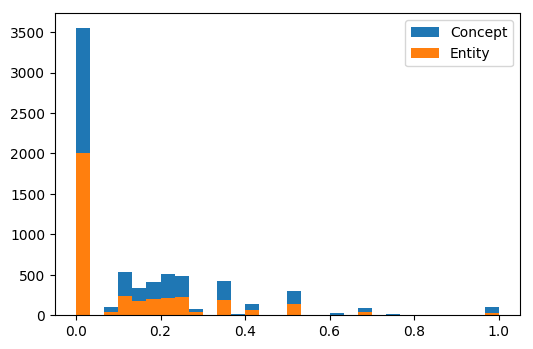

length_ratios


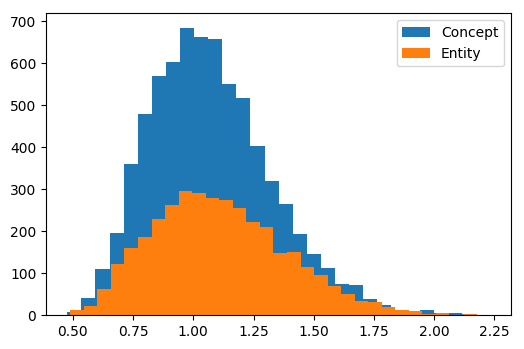

dag_number_of_paths


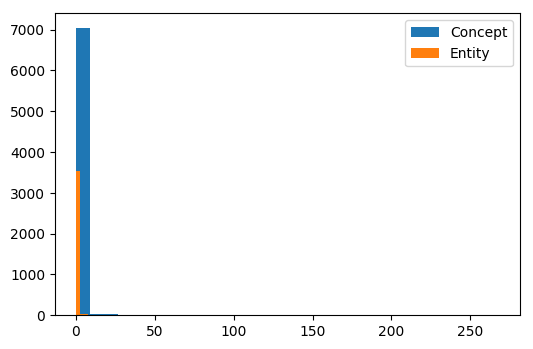

freq_ratios_log


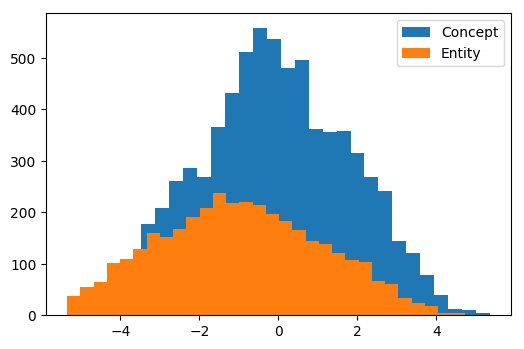

dag_avg_path_len


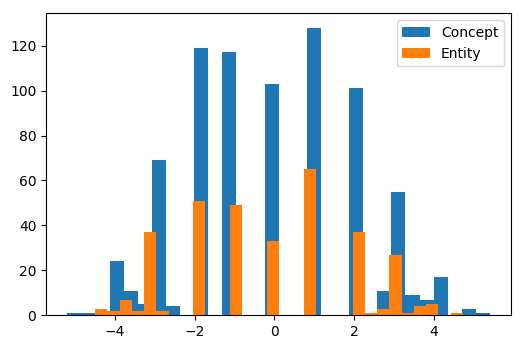

cosines


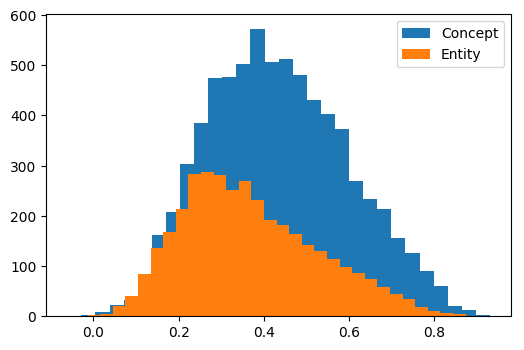

dag_shortest_path


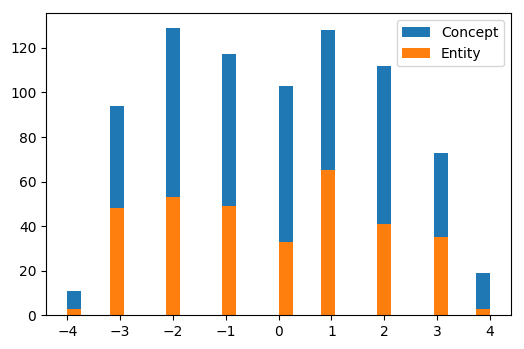

In [19]:
import matplotlib.pyplot as plt
for f in features.keys():
    print(f)
    for category in ['Concept', 'Entity']: 
        plt.hist([value for value in features[f][category] if value != -100], 30)
    plt.legend(['Concept', 'Entity'])
    plt.show()